<b>Project Objective</b>

Airbnb database files contain many features from which we can learn how Airbnb is being used
around the world, giving valuable insights for business entrepreneurs and policy planners. For
my project, Amsterdam was chosen as a database file since this is my next planned travel
destination after the pandemic ends.
In this work, I will use exploratory data analysis and machine learning modeling (linear regression, random forest, and XGBoost) for identifying factors that contribute to a listing price and giving forecasts for new listings. Hence, the objective variable I will be using is the price per night (price).
My main goal is to find the best machine learning model which will forecasts prices, to give a new host candidate at Airbnb insights into whether his listing would have the potential to become a profitable one.

In [1]:
#pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import scipy
# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import datetime
from datetime import date

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


In [3]:
df = pd.read_csv(r"/Users/dannystatland/Drive/MBA/data_science/Final_Project/listings_amsterdam.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,first_review,host_total_listings_count,accommodates,review_scores_value,bedrooms,amenities
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,Private room,59,3,278,14/02/2020,1.95,123,30/03/2009,1.0,2,10.0,1.0,"Lock on bedroom door, Carbon monoxide alarm, S..."
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,NaN,Centrum-Oost,Private room,236,1,339,09/04/2020,2.58,3,02/03/2010,2.0,2,9.0,1.0,"Wifi, Hot water, Hangers, Host greets you, Lon..."
2,25428,Lovely apt in City Centre (w.lift) near Jordaan,56142,Joan,NaN,Centrum-West,Entire home/apt,125,14,5,09/02/2020,0.14,33,21/01/2018,2.0,3,10.0,1.0,"Microwave, Refrigerator, Dishes and silverware..."
3,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,Private room,135,2,219,25/07/2020,2.01,219,09/01/2012,1.0,2,10.0,1.0,"Carbon monoxide alarm, Private living room, Re..."
4,28871,Comfortable double room,124245,Edwin,NaN,Centrum-Oost,Private room,75,2,336,20/09/2020,2.68,346,22/08/2010,2.0,2,10.0,1.0,"Wifi, Hot water, Private entrance, Hangers, Ho..."


<b>Data Description</b>

Let's have a look into the data variables and see which are valuable for us:
reviews per month - continues value, since it takes into account also the number of years this listing appears. id - discrete id value of the property, tells us nothing about price. Will be dropped. name - textual property name. Unlikely to be valuable for us, will be dropped. host_id - same as id. Will be dropped. host_name - same as name. Though it will be interesting to correlate the host's gender (for example) to the price of booking, we don't have the host's gender, so we will drop it. neighbourhood_group - this is an empty column, all values marked as nulls, hence we will drop it. neighborhood - categorial. Likely to impact listings' price. room type - categorial. Can influence price. price - continuous. This is our target variable. minimum nights - discrete. We can predict that a higher value will be correlated to lower price, as being a limiting factor. Will keep it. number of reviews - discrete. last review - DateTime of last review (and perhaps ordinal for the order the listings appeared in Airbnb). We will drop it. availability 365 - a discrete number of the number of days this property will be available in the following year. We will drop it as we don't care about future information. first review - DateTime of first-ever review of that property. Perhaps there will be a correlation between listing time in the market and price. accommodates - discrete indicator for the maximum number of guests a property can host, a variable that can be correlated to price. bedrooms - same as accommodates. review score value - an ordinal variable with values between 2 and 10. Likely to impact price. amenities - categorial. Lists different items and features available in a listing. We will use it in feature engineering.

Lets list all the features in the dataset:

In [4]:
df.columns.values

array(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'availability_365', 'first_review', 'host_total_listings_count',
       'accommodates', 'review_scores_value', 'bedrooms', 'amenities'],
      dtype=object)

Now, as explained in the data description section, lets drop all the features that cannot assist our objective:

In [5]:
df.drop(["name","id","host_id","host_name","neighbourhood_group","last_review"], axis=1, inplace=True)
df.head(2)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,first_review,host_total_listings_count,accommodates,review_scores_value,bedrooms,amenities
0,Oostelijk Havengebied - Indische Buurt,Private room,59,3,278,1.95,123,30/03/2009,1.0,2,10.0,1.0,"Lock on bedroom door, Carbon monoxide alarm, S..."
1,Centrum-Oost,Private room,236,1,339,2.58,3,02/03/2010,2.0,2,9.0,1.0,"Wifi, Hot water, Hangers, Host greets you, Lon..."


In [6]:
df.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,host_total_listings_count,accommodates,review_scores_value,bedrooms
count,18522.000000,18522.000000,18522.000000,16147.000000,18522.000000,18467.000000,18522.000000,15886.000000,17508.000000
mean,153.998218,3.597074,24.411133,0.637445,56.578501,2.727351,2.840514,9.202883,1.534384
std,149.124299,14.194230,54.648059,1.159044,111.719419,14.023101,1.285011,0.826273,0.951389
min,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,94.000000,2.000000,2.000000,0.130000,0.000000,1.000000,2.000000,9.000000,1.000000
50%,128.000000,2.000000,8.000000,0.300000,0.000000,1.000000,2.000000,9.000000,1.000000
75%,180.000000,3.000000,22.000000,0.620000,45.000000,1.000000,4.000000,10.000000,2.000000
max,8000.000000,1001.000000,858.000000,39.310000,365.000000,1089.000000,16.000000,10.000000,50.000000


We can see that there is a max of 18,522 entries (listed properties) in the data columns. 


# Dealing with missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18522 entries, 0 to 18521
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood              18522 non-null  object 
 1   room_type                  18522 non-null  object 
 2   price                      18522 non-null  int64  
 3   minimum_nights             18522 non-null  int64  
 4   number_of_reviews          18522 non-null  int64  
 5   reviews_per_month          16147 non-null  float64
 6   availability_365           18522 non-null  int64  
 7   first_review               16147 non-null  object 
 8   host_total_listings_count  18467 non-null  float64
 9   accommodates               18522 non-null  int64  
 10  review_scores_value        15886 non-null  float64
 11  bedrooms                   17508 non-null  float64
 12  amenities                  18470 non-null  object 
dtypes: float64(4), int64(5), object(4)
memory usag

As we can see, after dropping some columns we have left with 14. Each column has a range index of 18522 entries (number of rows). We will convert first_review from object to DateTime data type, to be able to use it later:

In [8]:
df["first_review"] = pd.to_datetime(df["first_review"])

We can also see that all columns with less than 18522 entries have missing (null) values. Let's present them in a clearer way.

In [9]:
df.isnull().any()

neighbourhood                False
room_type                    False
price                        False
minimum_nights               False
number_of_reviews            False
reviews_per_month             True
availability_365             False
first_review                  True
host_total_listings_count     True
accommodates                 False
review_scores_value           True
bedrooms                      True
amenities                     True
dtype: bool

"reviews_per_month", "first_review", "bedrooms", "amenities", "host_total_listings_count" and "review_scores_value" contain missing values.
"reviews_per_month" is our objective variable, reflecting our outcome (popularity). Hence properties with a missing value for this variable should be dropped, otherwise, we will get some biased results.
"first_review" was changed to a DateTime type variable, and is indicating the experience level of the property, thus can be correlated to popularity. We should fill the missing values with the mean date.
"bedrooms" and "review_scores_value" hold numerical values, so we can replace missing values with the mean in each.
"amenities" holds categorical values which we will later want to use, and there are not so many missing values, so we will simply fill them with the string "empty".
We will create another column to indicate artificial values (mean placed values). For the "bedroom" variable we can be even more accurate, and instead of just replacing empty values with the mean, we can first group by "accommodates" which has no empty values and describes the number of guests possible in that property (hence will be probably correlated to the number of bedrooms), and then choose the mean of the bedrooms for the value of "accommodates".

In [10]:
df.dropna(subset=["reviews_per_month"], inplace=True)
df.isnull().any()

neighbourhood                False
room_type                    False
price                        False
minimum_nights               False
number_of_reviews            False
reviews_per_month            False
availability_365             False
first_review                 False
host_total_listings_count     True
accommodates                 False
review_scores_value           True
bedrooms                      True
amenities                     True
dtype: bool

We see that "first_review" also turned to false, so all empty rows for this column were also empty for the "reviews_per_month" column and were therefore dropped.

In [11]:
#replace empty values with the mean of that variable and mark as artificial
df["review_scores_value_available"] = ~df["review_scores_value"].isnull()
df["review_scores_value"] = df["review_scores_value"].fillna(df["review_scores_value"].mean())
df["host_total_listings_count"] = df["host_total_listings_count"].fillna(df["host_total_listings_count"].mean())

#replace amenities ampty values with the string "empty"
df["amenities"] = df["amenities"].fillna("empty")

#get more accurate mean for missing values of "bedrooms" column by using "accomodates" column
df["accommodates_available"] = ~df["accommodates"].isnull()
df.groupby("accommodates")["bedrooms"].mean()

accommodates
1     1.031519
2     1.052453
3     1.521417
4     2.126250
5     2.915751
6     3.066176
7     3.742857
8     3.906977
9     2.500000
10    4.714286
12    4.111111
14    7.000000
16    8.130435
Name: bedrooms, dtype: float64

In [12]:
accomodates_bedrooms_dict = {1:1.03, 2:1.05, 3:1.52, 4:2.12, 5:2.91, 6:3.06, 7:3.74, 8:3.90, 9:2.50, 10:4.71, 12:4.11, 14:7.00, 16:8.13}
for key,val in accomodates_bedrooms_dict.items():
    df.loc[(df.bedrooms.isnull()) & (df.accommodates==key),"bedrooms"] = val


In [13]:
df.isna().any()

neighbourhood                    False
room_type                        False
price                            False
minimum_nights                   False
number_of_reviews                False
reviews_per_month                False
availability_365                 False
first_review                     False
host_total_listings_count        False
accommodates                     False
review_scores_value              False
bedrooms                         False
amenities                        False
review_scores_value_available    False
accommodates_available           False
dtype: bool

We have now finished handling missing data.

# Exploratory Data Analysis

Let's first analyze the distribution of our objective variable


<b>Density Estimation</b>

Advertised prices range from $5 to $8000.


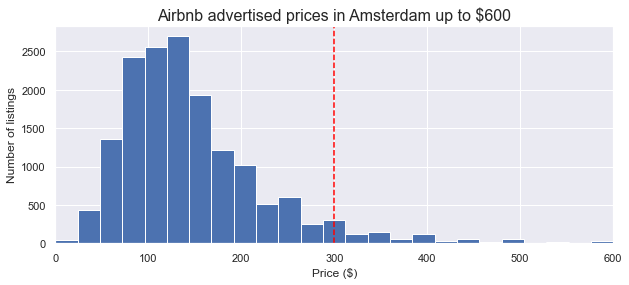

In [14]:
print(f"Advertised prices range from ${min(df.price)} to ${max(df.price)}.")
# Distribution of prices from $0 to $600
plt.figure(figsize=(10,4))
df.price.hist(bins=25, range=(0,600))
plt.margins(x=0)
plt.axvline(300, color='red', linestyle='--')
plt.title("Airbnb advertised prices in Amsterdam up to $600", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

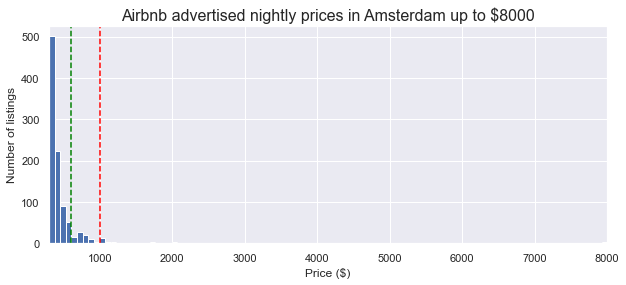

In [15]:
# Distribution of prices from $300 upwards
plt.figure(figsize=(10,4))
df.price.hist(bins=100, range=(300, max(df.price)))
plt.margins(x=0)
plt.axvline(600, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to $8000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [16]:
df.price.describe()

count    16147.000000
mean       152.322908
std        144.137562
min          5.000000
25%         95.000000
50%        127.000000
75%        180.000000
max       8000.000000
Name: price, dtype: float64

We can see the price distribution is right-skewed, I will therefore drop all values with prices lower than the mean + 2 std. This way we get rid of target variable outliers from the right while preserving 95% of the labels.

In [17]:
df = df[df.price < 600]

<b>Listing price by popularity</b>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, '(0, 20]'),
  Text(1, 0, '(20, 40]'),
  Text(2, 0, '(40, 60]'),
  Text(3, 0, '(60, 80]'),
  Text(4, 0, '(80, 100]'),
  Text(5, 0, '(100, 120]'),
  Text(6, 0, '(120, 140]'),
  Text(7, 0, '(140, 160]'),
  Text(8, 0, '(160, 180]'),
  Text(9, 0, '(180, 200]'),
  Text(10, 0, '(200, 220]'),
  Text(11, 0, '(220, 240]'),
  Text(12, 0, '(240, 260]'),
  Text(13, 0, '(260, 280]')])

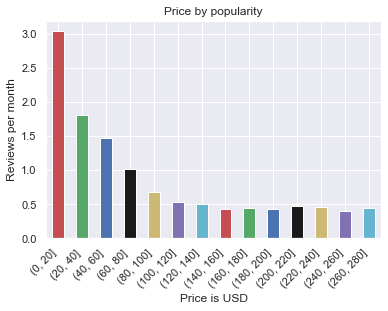

In [18]:
df['reviews_per_month'].groupby(pd.cut(df['price'], np.arange(0,300,20))).mean().plot(kind='bar', color=list('rgbkymc'))
plt.title("Price by popularity")
plt.ylabel("Reviews per month")
plt.xlabel("Price is USD")
plt.xticks(rotation=45, ha='right')


Text(0.5, 49.99999999999995, 'Price is USD')

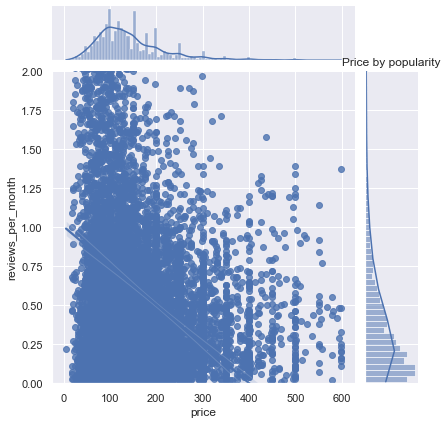

In [19]:
sns.jointplot(data=df, x="price", y="reviews_per_month", ylim=(0,2), kind='reg')
plt.title("Price by popularity")
plt.ylabel("Reviews per month")
plt.xlabel("Price is USD")

<b>Price by minimum nights</b>



In [20]:
df = df[df.minimum_nights < 18]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17')])

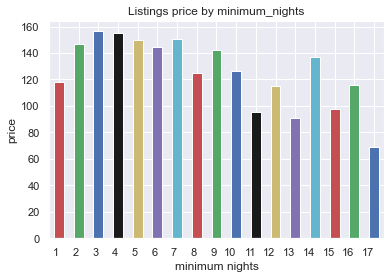

In [21]:
df['price'].groupby(df['minimum_nights']).mean().plot(kind='bar',color=list('rgbkymc'))
plt.title("Listings price by minimum_nights")
plt.xlabel("minimum nights")
plt.ylabel("price")
plt.xticks(rotation=0, ha='right')

<b>Price by neighbourhood</b> 

Now lets see if a listing is likely to be more expensive if offered in specific neighbourhoods:

Text(0.5, 0, 'price')

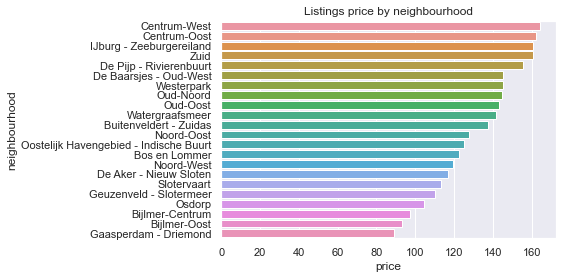

In [22]:
#Group neighbourhoods by average price value
df_new = df.groupby(["neighbourhood"], as_index=False).agg({"price":np.mean})
#Sort the subdata frame by price
df_new = df_new.sort_values(by=["price"], ascending=False)
sns.barplot(x="price", y="neighbourhood", data=df_new)
plt.title("Listings price by neighbourhood")
plt.ylabel('neighbourhood')
plt.xlabel('price')

<b>Listing price by room type</b>

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Entire home/apt'),
  Text(1, 0, 'Hotel room'),
  Text(2, 0, 'Private room'),
  Text(3, 0, 'Shared room')])

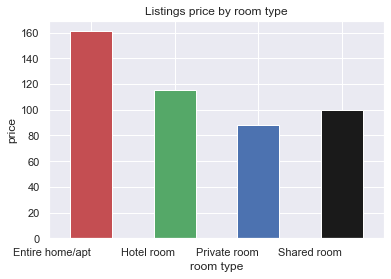

In [23]:
df['price'].groupby(df['room_type']).mean().plot(kind='bar',color=list('rgbkymc'))
plt.title("Listings price by room type")
plt.xlabel("room type")
plt.ylabel("price")
plt.xticks(rotation=0, ha='right')

Text(0.5, 1.0, 'Listings price by room type')

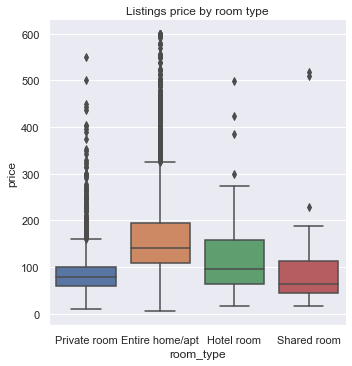

In [24]:
sns.catplot(x="room_type", y="price", kind="box", data=df)
plt.title("Listings price by room type")

<b>Price by accommodates</b>

Text(0.5, 0, 'accommodates')

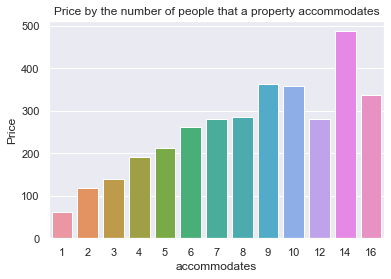

In [25]:
df_new = df.groupby(["accommodates"], as_index=False).agg({"price":np.mean})
df_new = df_new.sort_values(by=["price"], ascending=False)
sns.barplot(y="price", x="accommodates", data=df_new)
plt.title("Price by the number of people that a property accommodates")
plt.ylabel("Price")
plt.xlabel("accommodates")

<b>Price by number of reviews</b>

<Figure size 720x288 with 0 Axes>

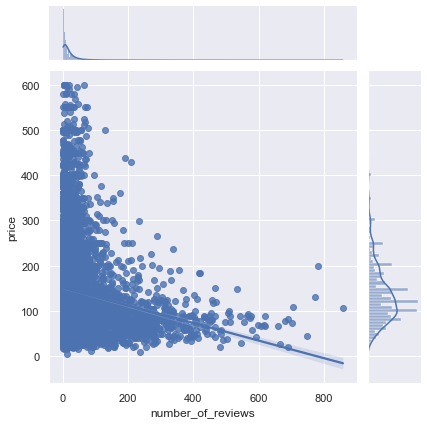

In [26]:
plt.figure(figsize=(10,4))
sns.jointplot(data=df,x='number_of_reviews', y='price',kind='reg')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 [Text(0, 0, '(0, 5]'),
  Text(1, 0, '(5, 10]'),
  Text(2, 0, '(10, 15]'),
  Text(3, 0, '(15, 20]'),
  Text(4, 0, '(20, 25]'),
  Text(5, 0, '(25, 30]'),
  Text(6, 0, '(30, 35]'),
  Text(7, 0, '(35, 40]'),
  Text(8, 0, '(40, 45]'),
  Text(9, 0, '(45, 50]'),
  Text(10, 0, '(50, 55]'),
  Text(11, 0, '(55, 60]'),
  Text(12, 0, '(60, 65]'),
  Text(13, 0, '(65, 70]'),
  Text(14, 0, '(70, 75]'),
  Text(15, 0, '(75, 80]'),
  Text(16, 0, '(80, 85]'),
  Text(17, 0, '(85, 90]'),
  Text(18, 0, '(90, 95]'),
  Text(19, 0, '(95, 100]'),
  Text(20, 0, '(100, 105]'),
  Text(21, 0, '(105, 110]'),
  Text(22, 0, '(110, 115]'),
  Text(23, 0, '(115, 120]'),
  Text(24, 0, '(120, 125]'),
  Text(25, 0, '(125, 130]'),
  Text(26, 0, '(130, 135]'),
  Text(27, 0, '(135, 140]'),
  Text(28, 0, '(140, 145]'),
  Text(29, 0, '(145, 150]'),


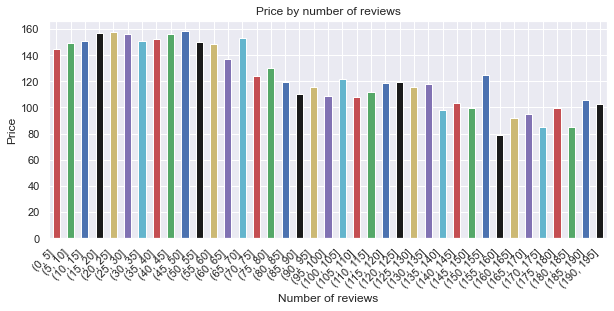

In [27]:
plt.figure(figsize=(10,4))
df['price'].groupby(pd.cut(df['number_of_reviews'], np.arange(0,200,5))).mean().plot(kind='bar', color=list('rgbkymc'))
plt.margins(x=0)
plt.title("Price by number of reviews")
plt.ylabel("Price")
plt.xlabel("Number of reviews")
plt.xticks(rotation=45, ha='right')

# Feature Engineering

<b>New feature: price by bed-guest ratio</b>


In [28]:
df["bed_guest_ratio"] = df["bedrooms"] / df["accommodates"]
df["bed_guest_ratio"].head(5)

0    0.500000
1    0.500000
2    0.333333
3    0.500000
4    0.500000
Name: bed_guest_ratio, dtype: float64

In [29]:
df.bed_guest_ratio.describe()

count    15841.000000
mean         0.537299
std          0.202841
min          0.083333
25%          0.500000
50%          0.500000
75%          0.500000
max         15.000000
Name: bed_guest_ratio, dtype: float64

<b>New feature: price by number of amenities</b>



In [30]:
df["count_amenities"] = df["amenities"].str.count('\w+')
df["count_amenities"].head(5)

0    57
1    35
2    47
3    46
4    27
Name: count_amenities, dtype: int64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '(0.876, 25.8]'),
  Text(1, 0, '(25.8, 50.6]'),
  Text(2, 0, '(50.6, 75.4]'),
  Text(3, 0, '(75.4, 100.2]'),
  Text(4, 0, '(100.2, 125.0]')])

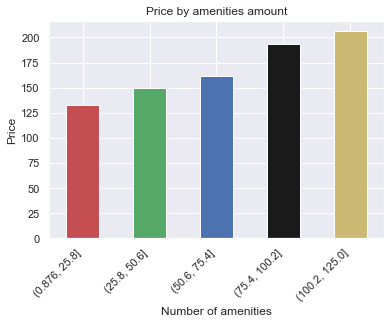

In [31]:
df['price'].groupby(pd.cut(df['count_amenities'], 5)).mean().plot(kind='bar', color=list('rgbkymc'))
plt.title("Price by amenities amount")
plt.ylabel("Price")
plt.xlabel("Number of amenities")
plt.xticks(rotation=45, ha='right')

# Further pre-processing

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15841 entries, 0 to 18506
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   neighbourhood                  15841 non-null  object        
 1   room_type                      15841 non-null  object        
 2   price                          15841 non-null  int64         
 3   minimum_nights                 15841 non-null  int64         
 4   number_of_reviews              15841 non-null  int64         
 5   reviews_per_month              15841 non-null  float64       
 6   availability_365               15841 non-null  int64         
 7   first_review                   15841 non-null  datetime64[ns]
 8   host_total_listings_count      15841 non-null  float64       
 9   accommodates                   15841 non-null  int64         
 10  review_scores_value            15841 non-null  float64       
 11  bedrooms       

In [33]:
#drop irrelevant columns
df.drop(["amenities", "accommodates_available", "review_scores_value_available"], axis=1, inplace=True)

In [34]:
#convert datetime datatype to ordinal dataype to enable sklearn modeling
df['first_review'] = df['first_review'].apply(lambda x: x.toordinal())

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15841 entries, 0 to 18506
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood              15841 non-null  object 
 1   room_type                  15841 non-null  object 
 2   price                      15841 non-null  int64  
 3   minimum_nights             15841 non-null  int64  
 4   number_of_reviews          15841 non-null  int64  
 5   reviews_per_month          15841 non-null  float64
 6   availability_365           15841 non-null  int64  
 7   first_review               15841 non-null  int64  
 8   host_total_listings_count  15841 non-null  float64
 9   accommodates               15841 non-null  int64  
 10  review_scores_value        15841 non-null  float64
 11  bedrooms                   15841 non-null  float64
 12  bed_guest_ratio            15841 non-null  float64
 13  count_amenities            15841 non-null  int

In [36]:
#create dummies for categorical features
df_dummies = pd.get_dummies(df)
df_dummies.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,first_review,host_total_listings_count,accommodates,review_scores_value,bedrooms,...,neighbourhood_Oud-Noord,neighbourhood_Oud-Oost,neighbourhood_Slotervaart,neighbourhood_Watergraafsmeer,neighbourhood_Westerpark,neighbourhood_Zuid,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,59,3,278,1.95,123,733496,1.0,2,10.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,236,1,339,2.58,3,733806,2.0,2,9.0,1.0,...,0,0,0,0,0,0,0,0,1,0
2,125,14,5,0.14,33,736715,2.0,3,10.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3,135,2,219,2.01,219,734747,1.0,2,10.0,1.0,...,0,0,0,0,0,0,0,0,1,0
4,75,2,336,2.68,346,734006,2.0,2,10.0,1.0,...,0,0,0,0,0,0,0,0,1,0


## Dealing with multicollinearity

In [37]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

/var/folders/gw/vxqmwd8s7hlczjd80y61sph40000gn/T/ipykernel_22160/1066291845.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


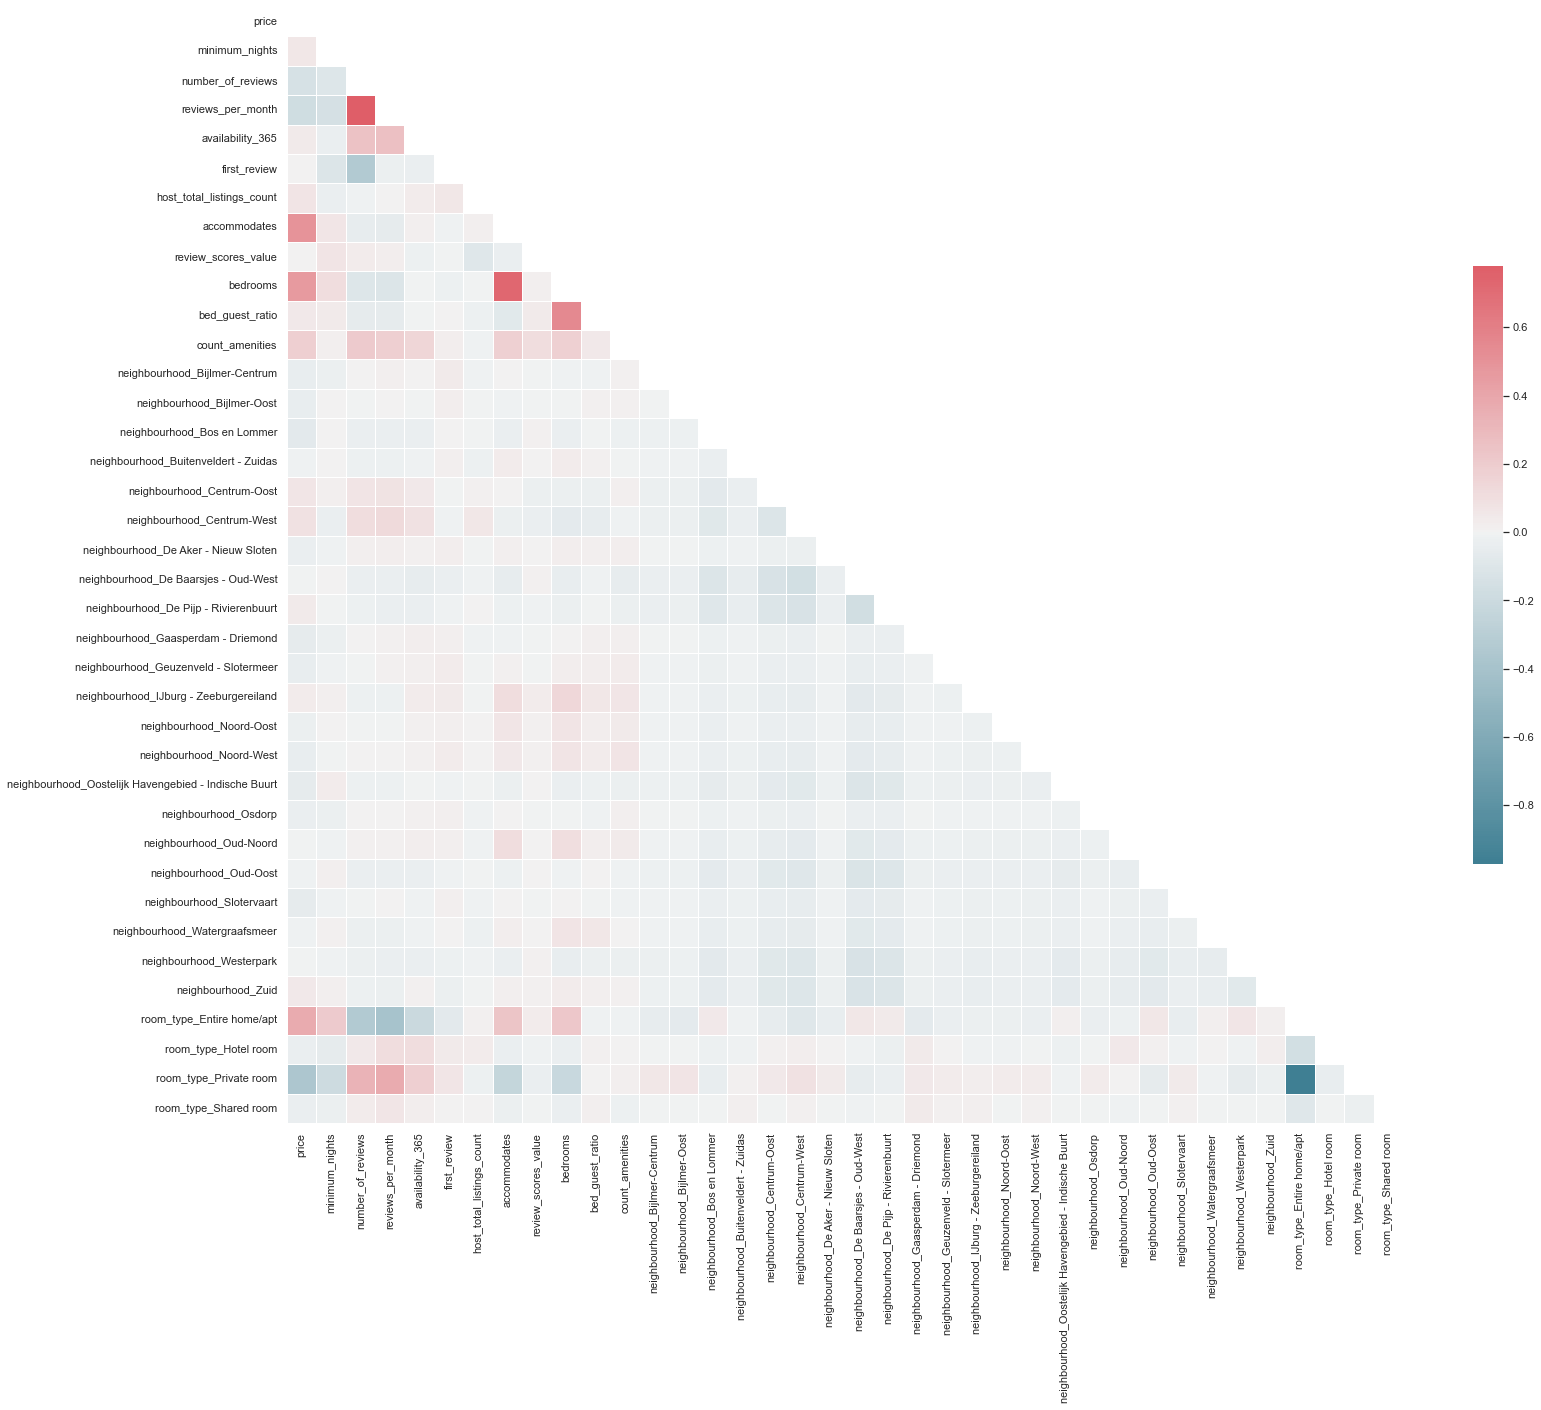

In [38]:
multi_collinearity_heatmap(df_dummies.drop(list(df_dummies.columns[df_dummies.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

In [39]:
# Dropping collinear features
to_drop = ['room_type_Private room','bedrooms','reviews_per_month']
to_drop.extend(list(df_dummies.columns[df_dummies.columns.str.endswith('nan')]))

df_dummies.drop(to_drop, axis=1, inplace=True)

/var/folders/gw/vxqmwd8s7hlczjd80y61sph40000gn/T/ipykernel_22160/1066291845.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


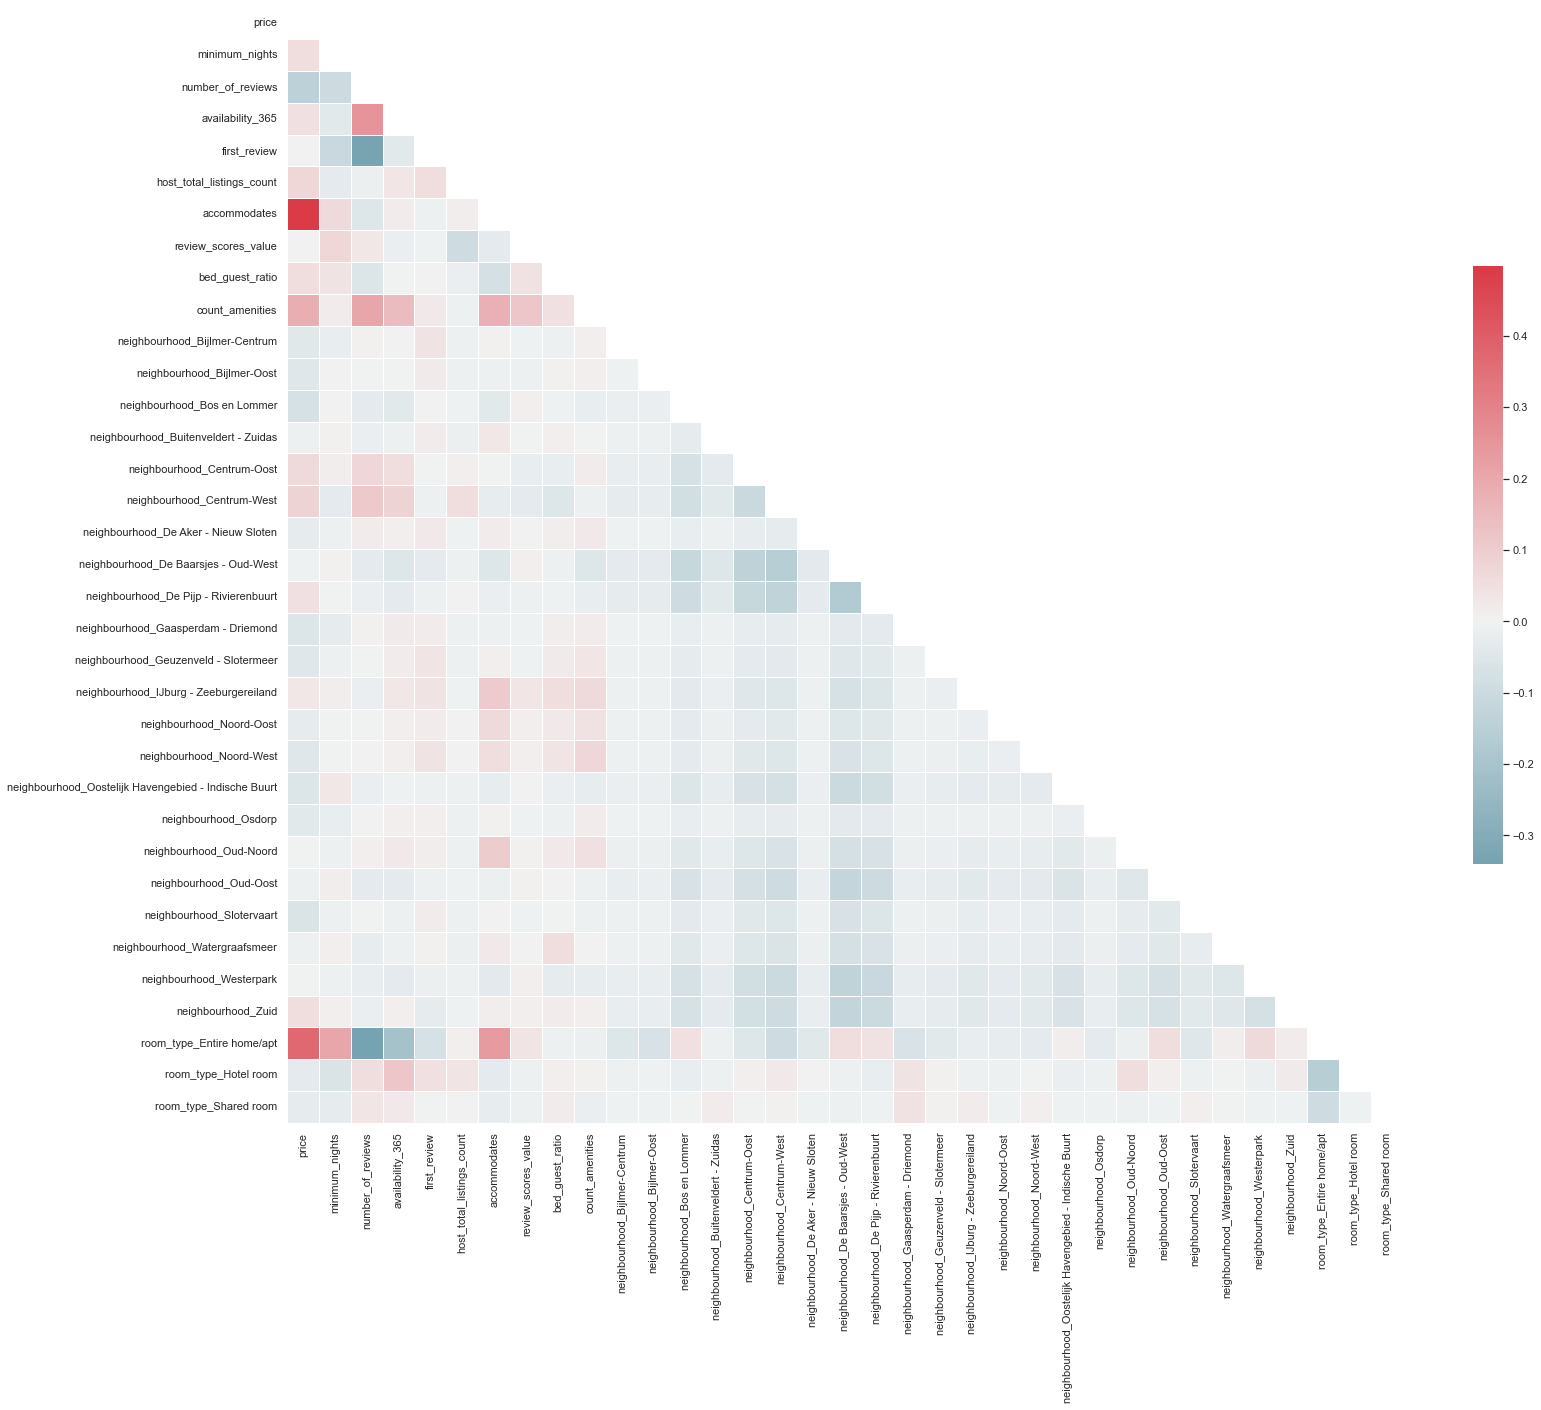

In [40]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(df_dummies.drop(list(df_dummies.columns[df_dummies.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

## Standardising and normalizing

Other than `price`, `first_review`, and `count_amenities`, the remaining numerical features are all positively or negatively skewed and could benefit from log transformation.

In [41]:
numerical_columns = ['price','minimum_nights','number_of_reviews','availability_365','first_review','accommodates','bed_guest_ratio','review_scores_value','count_amenities']

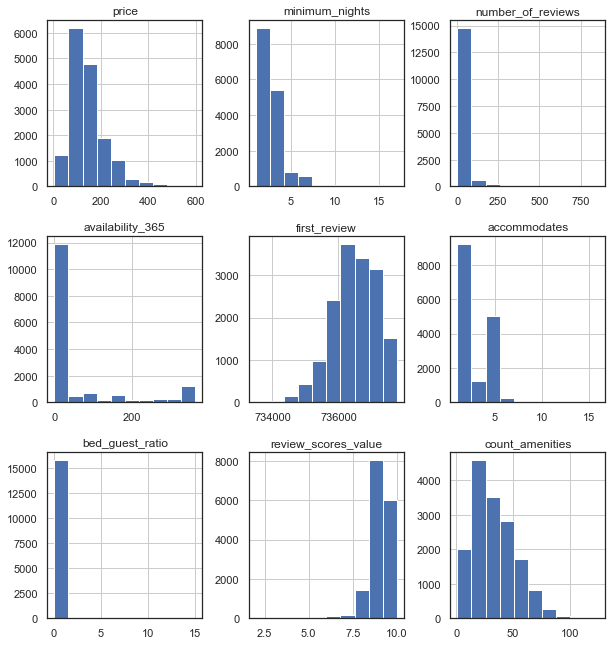

In [42]:
df_dummies[numerical_columns].hist(figsize=(10,11));

In [43]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['review_scores_value','price']] # Removing items not to be transformed

for col in numerical_columns:
    df_dummies[col] = df_dummies[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df_dummies[col] = np.log(df_dummies[col])

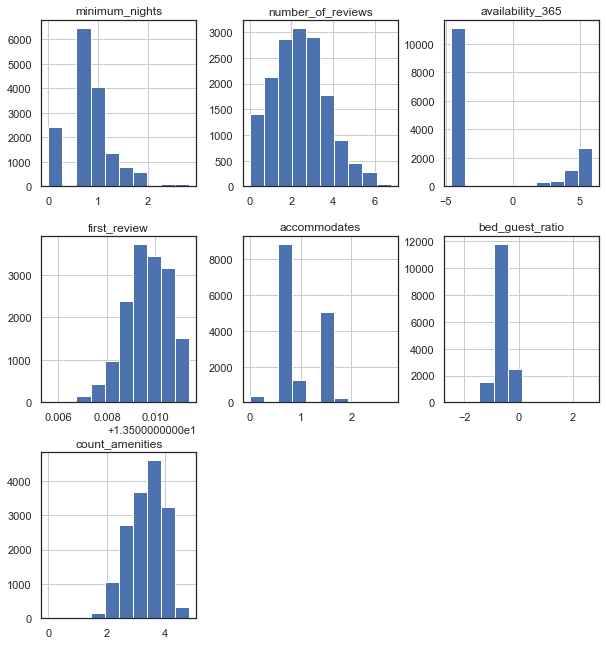

In [44]:
df_dummies[numerical_columns].hist(figsize=(10,11));

# Modeling

Now that the data preprocessing is over, we can start applying different Supervised Machine Learning models. We will compare three models:

1. LinearRegression from Scikit-Learn library
2.XGBoost
3. Random Forest

The evaluation metrics used will be mean squared error and others (for loss) and r-squared (for accuracy).

In [45]:
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import xgboost as xgb
from xgboost import plot_importance

In [46]:
# Scaling
X = df_dummies 
y = X.pop('price')

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=123) 

## Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import math
lr_model = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(lr_model, X, y, cv=5)
train_predicts = lr_model.predict(X_train)
test_predicts = lr_model.predict(X_test)
print("\nTraining r2:", round(r2_score(y_train, train_predicts),4))
print("Validation r2:", round(r2_score(y_test, test_predicts),4))
print("\nMean 10-fold cross_validation score:", round(scores.mean(),4))

# Check the predictions against the actual values by using the MSE and R-2 metrics:
#The loss functions measure the distance between our predicted values and actual values.
print("\nTraining RMSE:", round(mean_squared_error(y_train, train_predicts),4))
print("Validation RMSE:", round(mean_squared_error(y_test, test_predicts),4))
print("\nTraining MAE:", round(math.sqrt(mean_absolute_error(y_train, train_predicts)),4))
print("Validation MAE:", round(math.sqrt(mean_absolute_error(y_test, test_predicts)),4))
print("\nTraining MedAE:", round(median_absolute_error(y_train, train_predicts),4))
print("Validation MedAE:", round(median_absolute_error(y_test, test_predicts),4))
print("\nTraining MAPE:", round(mean_absolute_percentage_error(y_train, train_predicts),4))
print("Validation MAPE:", round(mean_absolute_percentage_error(y_test, test_predicts),4))


Training r2: 0.4045
Validation r2: 0.4187

Mean 10-fold cross_validation score: 0.3969

Training RMSE: 3771.8225
Validation RMSE: 3636.6445

Training MAE: 6.5378
Validation MAE: 6.4668

Training MedAE: 30.5751
Validation MedAE: 30.2548

Training MAPE: 0.3398
Validation MAPE: 0.3432


We can compare the actual output values for `X_test` with the predicted values in a dataframe:

/var/folders/gw/vxqmwd8s7hlczjd80y61sph40000gn/T/ipykernel_22160/766261829.py:7: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')


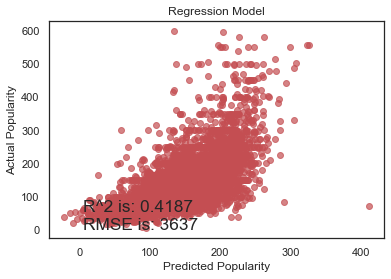

In [49]:
actual_values = y_test
plt.scatter(test_predicts, actual_values, alpha=.7,
            color='r') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, test_predicts),4)),
                    (round(mean_squared_error(y_test, test_predicts))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.title('Regression Model')
plt.show()

## Boosting with XGBoost


Training r2: 0.524
Validation r2: 0.4743

Mean 10-fold cross_validation score: 0.4446

Training RMSE: 54.907171662725446
Validation RMSE: 57.34914559084555

Training MAE: 6.1400081433170755
Validation MAE: 6.276965827531643

Training MedAE: 26.8811
Validation MedAE: 27.7516

Training MAPE: 0.2943
Validation MAPE: 0.3207


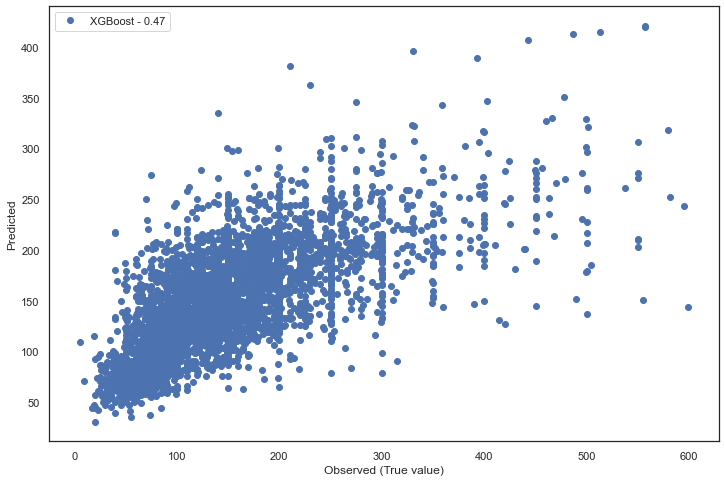

In [50]:

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
              max_depth = 5, alpha = 100, n_estimators = 75)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)
cross = cross_val_score(xgb_reg, X, y, cv=10)

print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))
print("\nMean 10-fold cross_validation score:", round(cross.mean(),4))
print("\nTraining RMSE:", math.sqrt(round(mean_squared_error(y_train, training_preds_xgb_reg),4)))
print("Validation RMSE:", math.sqrt(round(mean_squared_error(y_test, val_preds_xgb_reg),4)))
print("\nTraining MAE:", math.sqrt(round(mean_absolute_error(y_train, training_preds_xgb_reg),4)))
print("Validation MAE:", math.sqrt(round(mean_absolute_error(y_test, val_preds_xgb_reg),4)))
print("\nTraining MedAE:", round(median_absolute_error(y_train, training_preds_xgb_reg),4))
print("Validation MedAE:", round(median_absolute_error(y_test, val_preds_xgb_reg),4))
print("\nTraining MAPE:", round(mean_absolute_percentage_error(y_train, training_preds_xgb_reg),4))
print("Validation MAPE:", round(mean_absolute_percentage_error(y_test, val_preds_xgb_reg),4))


fig = plt.figure(figsize=(12,8));
rf_plot = plt.plot(y_test, xgb_reg.predict(X_test), 'ob',label = 'XGBoost - {0:2.2f}'.format(xgb_reg.score(X_test,y_test)))
plt.legend(loc = 2 )
plt.xlabel('Observed (True value)'); plt.ylabel('Predicted');

## Feature importance

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

In [51]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(50)

,weight
accommodates,0.229384
room_type_Entire home/apt,0.195898
bed_guest_ratio,0.059607
neighbourhood_Centrum-West,0.050749
neighbourhood_Zuid,0.037178
neighbourhood_Centrum-Oost,0.029216
neighbourhood_Noord-West,0.028584
neighbourhood_De Pijp - Rivierenbuurt,0.024879
neighbourhood_Bos en Lommer,0.023961
neighbourhood_Oostelijk Havengebied - Indische Buurt,0.022921


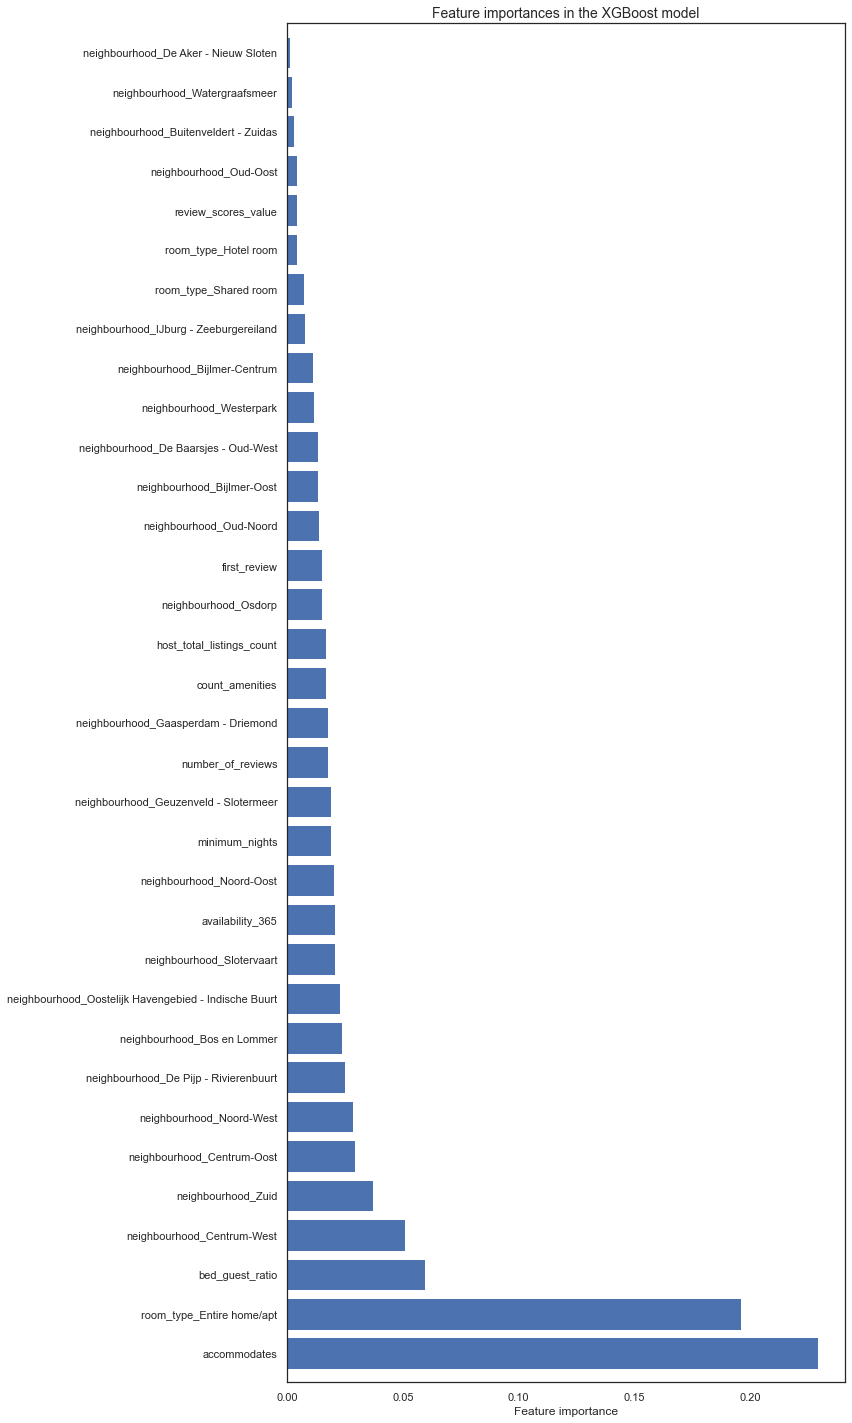

In [52]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## It's interesting to note that our engineered feature "bed-guest ratio" is ranked as the 3rd (!) most important feature.

## Bagging with Random forest

Training Score: 0.4323436722046031
Validation Score: 0.3977657917059001

Mean 10-fold cross_validation score: 0.3803

Training RMSE: 3595.4114
validation RMSE: 3767.5239

Training MAE: 6.4485
Validation MAE: 6.5095

Training MedAE: 29.7678
Validation MedAE: 29.9703

Training MAPE: 0.3286
Validation MAPE: 0.3462


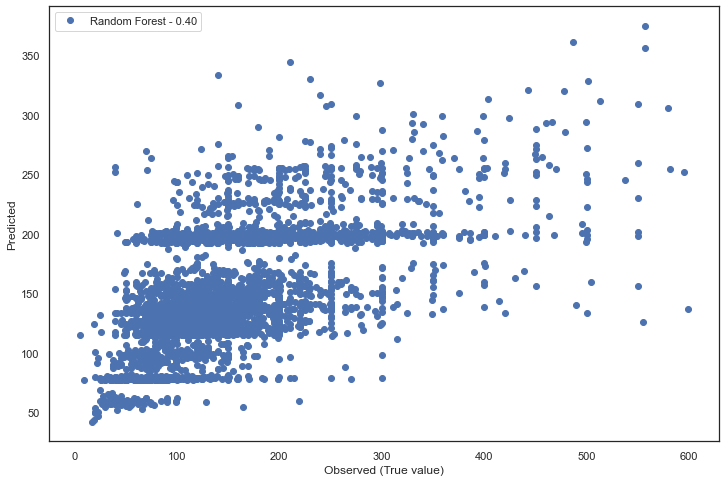

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50,n_jobs=-1, max_depth = 6)
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_test)
cross = cross_val_score(rf, X, y, cv=10)
print("Training Score:", rf.score(X_train, y_train))
print("Validation Score:", rf.score(X_test, y_test))
print("\nMean 10-fold cross_validation score:", round(cross.mean(),4))
print("\nTraining RMSE:", round(mean_squared_error(y_train, train_pred),4))
print("validation RMSE:", round(mean_squared_error(y_test, val_pred),4))
print("\nTraining MAE:", round(math.sqrt(mean_absolute_error(y_train, train_pred)),4))
print("Validation MAE:", round(math.sqrt(mean_absolute_error(y_test, val_pred)),4))
print("\nTraining MedAE:", round(median_absolute_error(y_train, train_pred),4))
print("Validation MedAE:", round(median_absolute_error(y_test, val_pred),4))
print("\nTraining MAPE:", round(mean_absolute_percentage_error(y_train, train_pred),4))
print("Validation MAPE:", round(mean_absolute_percentage_error(y_test, val_pred),4))
fig = plt.figure(figsize=(12,8));
rf_plot = plt.plot(y_test, rf.predict(X_test), 'ob',label = 'Random Forest - {0:2.2f}'.format(rf.score(X_test,y_test)))
plt.legend(loc = 2 )
plt.xlabel('Observed (True value)'); plt.ylabel('Predicted');

In [54]:
ft_weights_xgb_reg = pd.DataFrame(rf.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

,weight
accommodates,0.583838
room_type_Entire home/apt,0.169124
bed_guest_ratio,0.057341
availability_365,0.039063
neighbourhood_Centrum-West,0.032397
count_amenities,0.031979
host_total_listings_count,0.024664
first_review,0.016283
number_of_reviews,0.014493
neighbourhood_Centrum-Oost,0.006363


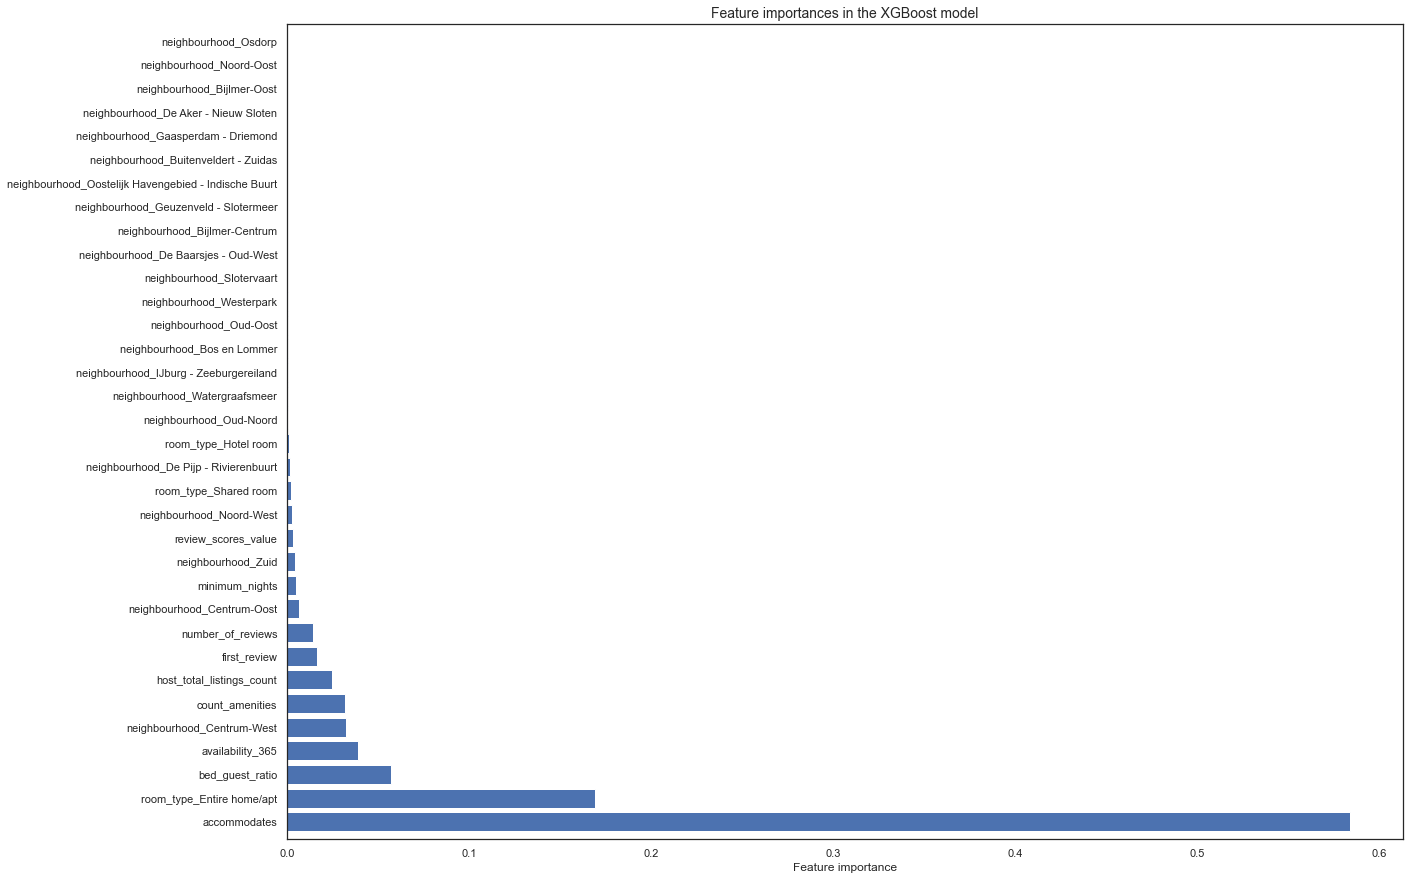

In [55]:
# Plotting feature importances
plt.figure(figsize=(20,15))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

It's interesting to note that our engineered features "bed-guest ratio" and "count_amenities" are ranked as the 3rd and 6th (!) most important feature correspondingly.

Conclusion: XGBoost is the preferred model, though it can be fine-tuned for performance improvement. Future remarks: model can be further optimized by dropping nonimportant features discovered by XGBoost, and by categorizing the target variable into bins, the accuracy should improve.